In [325]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy.linalg as la
import pandas as pd
from scipy.linalg import svd
from mpl_toolkits.mplot3d import Axes3D
import random
from pipeline import generate_basic_exploration

In [326]:
df = pd.read_csv('allegations_cleaned2.csv')

In [327]:
for x in df.columns:
    print(x)

Unnamed: 0
rank_abbrev_incident
mos_gender
mos_age_incident
same_ethnicity
closure_time
demotion
promotion
rank_abbrev_now
dispute
vehicle
suspected_violation
phone
warrant
aided_case
checkpoint
demonstrations_protests
report
disturbance
precinct_complaint_info
vehicle_violation
arrest_resist
arrest_obstruct
other_summons
Arrest/Complainant
C/V intervened on behalf of/observed encounter w/3rd party
C/V at PCT to file complaint of crime
Regulatory inspection
Assist ACS or other agency
CV already in custody
Report-gun possession/shots fired
Stop/Question/Frisk
C/V requested info from officer
Patrol Encounter
Arrest/Not Complainant
Summons/Complainant
Complainant Witnessing Incident
C/V at PCT to retrieve property
Parade/special event
Victim Subject of Sex Crime
No contact
Arrest - other violation/crime
No arrest made or summons issued
Assault/Arrested
Arrest - harrassment (against a PO)
Arrest on Other Charge
Harrassment/Arrested/Summons
Arrest - disorderly conduct
Arrest - assault (agai

In [356]:
# small subset 
keep_vars = ['mos_gender','mos_age_incident','mos_hispanic','mos_black',
             'mos_asian','mos_american_indian','complainant_age_incident','abuse_of_authority',
            'offensive_language','discourtesy','force',"c_black","c_unknown","c_white","c_asian","c_hispanic",
"c_american_indian",
"c_female",
"c_male",
"c_transman_(ftm)",
"c_transwoman_(mtf)",
"c_gender_non-conforming","officer_id","outcome"]

In [357]:
df = df[keep_vars]

In [358]:
#df[['closure_time']].hist()

In [359]:
df.describe()

mos_gender  mos_age_incident  mos_hispanic     mos_black  \
count  33358.000000      33358.000000  33358.000000  33358.000000   
mean       0.052761         32.346873      0.274297      0.147611   
std        0.223559          6.040944      0.446166      0.354719   
min        0.000000         20.000000      0.000000      0.000000   
25%        0.000000         28.000000      0.000000      0.000000   
50%        0.000000         31.000000      0.000000      0.000000   
75%        0.000000         36.000000      1.000000      0.000000   
max        1.000000         60.000000      1.000000      1.000000   

          mos_asian  mos_american_indian  complainant_age_incident  \
count  33358.000000         33358.000000              33358.000000   
mean       0.035314             0.000959                 32.262126   
std        0.184575             0.030958                 11.326145   
min        0.000000             0.000000                  1.000000   
25%        0.000000             0.000000                 24.000000   
50%        0.000000             0.000000                 30.000000   
75%        0.000000             0.000000                 38.000000   
max        1.000000             1.000000                101.000000   

       abuse_of_authority  offensive_language   discourtesy  ...  \
count        33358.000000        33358.000000  33358.000000  ...   
mean             0.608310            0.022573      0.140206  ...   
std              0.488135            0.148541      0.347206  ...   
min              0.000000            0.000000      0.000000  ...   
25%              0.000000            0.000000      0.000000  ...   
50%              1.000000            0.000000      0.000000  ...   
75%              1.000000            0.000000      0.000000  ...   
max              1.000000            1.000000      1.000000  ...   

            c_asian    c_hispanic  c_american_indian      c_female  \
count  33358.000000  33358.000000       33358.000000  33358.000000   
mean       0.015948      0.192577           0.001919      0.150519   
std        0.125277      0.394330           0.043760      0.357584   
min        0.000000      0.000000           0.000000      0.000000   
25%        0.000000      0.000000           0.000000      0.000000   
50%        0.000000      0.000000           0.000000      0.000000   
75%        0.000000      0.000000           0.000000      0.000000   
max        1.000000      1.000000           1.000000      1.000000   

             c_male  c_transman_(ftm)  c_transwoman_(mtf)  \
count  33358.000000      33358.000000        33358.000000   
mean       0.721206          0.000150            0.000600   
std        0.448413          0.012242            0.024479   
min        0.000000          0.000000            0.000000   
25%        0.000000          0.000000            0.000000   
50%        1.000000          0.000000            0.000000   
75%        1.000000          0.000000            0.000000   
max        1.000000          1.000000            1.000000   

       c_gender_non-conforming    officer_id       outcome  
count             33358.000000  33358.000000  33358.000000  
mean                  0.000060  18169.912495     -0.214251  
std                   0.007743   9566.316896      0.816125  
min                   0.000000      2.000000     -1.000000  
25%                   0.000000   9671.000000     -1.000000  
50%                   0.000000  19215.000000      0.000000  
75%                   0.000000  25412.000000      0.000000  
max                   1.000000  36374.000000      1.000000  

[8 rows x 24 columns]

In [360]:
df.shape

(33358, 24)

In [361]:
# Group train/test by officer ID somehow? See Piazza post
def train_test_split(df,holdOut=0.2, randomState = 1):
    # Train, val, test split:
    # get number of unique ids and the uniqe IDs
    n_ID = len(df.officer_id.unique())
    ids = pd.DataFrame(df.officer_id.unique())

    # sample from IDs
    train_index = ids.sample(round(n_ID*(1-holdOut)),random_state = randomState ).values.tolist()
    #train_index = [item for sublist in train_index for item in sublist]
    train_index = [x[0] for x in train_index]
    # train data is data from any IDs that show up in train index
    train_data = df[df.officer_id.isin(train_index)]
    # test data is data from any IDs that don't show up in train index
    test_data = df[~df.officer_id.isin(train_index)]

    # Sanity check
    print("Total Number of Unique IDs:" , len(df.officer_id.unique()))
    print("Total Number of IDs in Test Data:" , len(test_data.officer_id.unique()))
    print("Total Number of IDs in Train Data:" , len(train_data.officer_id.unique()))
    print("Do the IDs add up?" , len(test_data.officer_id.unique()) + len(train_data.officer_id.unique())  ==  len(df.officer_id.unique()))
    print("Does Test Represent 20% of the data?", (len(test_data.officer_id.unique())/len(df.officer_id.unique())) == holdOut)
    print("Test Represents X% of the data:", (len(test_data.officer_id.unique())/len(df.officer_id.unique())))
    
    return train_data, test_data

In [362]:
train,test = train_test_split(df)

Total Number of Unique IDs: 3996
Total Number of IDs in Test Data: 799
Total Number of IDs in Train Data: 3197
Do the IDs add up? True
Does Test Represent 20% of the data? False
Test Represents X% of the data: 0.19994994994994994


In [363]:
train.columns

Index(['mos_gender', 'mos_age_incident', 'mos_hispanic', 'mos_black',
       'mos_asian', 'mos_american_indian', 'complainant_age_incident',
       'abuse_of_authority', 'offensive_language', 'discourtesy', 'force',
       'c_black', 'c_unknown', 'c_white', 'c_asian', 'c_hispanic',
       'c_american_indian', 'c_female', 'c_male', 'c_transman_(ftm)',
       'c_transwoman_(mtf)', 'c_gender_non-conforming', 'officer_id',
       'outcome'],
      dtype='object')

In [364]:
# construct type of FADO as outcome
train['fado'] = np.nan
train.loc[train['abuse_of_authority']==1,'fado']=1
train.loc[train['discourtesy']==1,'fado']=2
train.loc[train['offensive_language']==1,'fado']=3
train.loc[train['force']==1,'fado']=4
train.drop(['abuse_of_authority',"discourtesy",'offensive_language','force'],axis=1,inplace=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [365]:
outcome_var = "outcome"

# first let's sort on outcome 
train = train.sort_values(by=outcome_var)
train.tail()

mos_gender  mos_age_incident  mos_hispanic  mos_black  mos_asian  \
18054         0.0              36.0           0.0        0.0        0.0   
18065         0.0              42.0           1.0        0.0        0.0   
18084         0.0              40.0           0.0        0.0        0.0   
18087         0.0              43.0           0.0        0.0        0.0   
33357         0.0              36.0           0.0        0.0        0.0   

       mos_american_indian  complainant_age_incident  c_black  c_unknown  \
18054                  0.0                      39.0      0.0        0.0   
18065                  0.0                      24.0      0.0        0.0   
18084                  0.0                      15.0      1.0        0.0   
18087                  0.0                      23.0      0.0        0.0   
33357                  0.0                      21.0      0.0        0.0   

       c_white  ...  c_hispanic  c_american_indian  c_female  c_male  \
18054      0.0  ...         1.0                0.0       0.0     1.0   
18065      0.0  ...         1.0                0.0       0.0     1.0   
18084      0.0  ...         0.0                0.0       0.0     1.0   
18087      0.0  ...         1.0                0.0       1.0     0.0   
33357      0.0  ...         0.0                0.0       0.0     1.0   

       c_transman_(ftm)  c_transwoman_(mtf)  c_gender_non-conforming  \
18054               0.0                 0.0                      0.0   
18065               0.0                 0.0                      0.0   
18084               0.0                 0.0                      0.0   
18087               0.0                 0.0                      0.0   
33357               0.0                 0.0                      0.0   

       officer_id  outcome  fado  
18054       25490      1.0   1.0  
18065       25495      1.0   2.0  
18084       25499      1.0   1.0  
18087       25499      1.0   1.0  
33357        9992      1.0   1.0  

[5 rows x 21 columns]

In [366]:
train.shape, 13945+12621

((26566, 21), 26566)

In [368]:
train

mos_gender  mos_age_incident  mos_hispanic  mos_black  mos_asian  \
26451         0.0              28.0           0.0        0.0        0.0   
21265         0.0              31.0           1.0        0.0        0.0   
30197         0.0              36.0           0.0        0.0        1.0   
11785         0.0              30.0           0.0        1.0        0.0   
11786         0.0              30.0           0.0        1.0        0.0   
...           ...               ...           ...        ...        ...   
18054         0.0              36.0           0.0        0.0        0.0   
18065         0.0              42.0           1.0        0.0        0.0   
18084         0.0              40.0           0.0        0.0        0.0   
18087         0.0              43.0           0.0        0.0        0.0   
33357         0.0              36.0           0.0        0.0        0.0   

       mos_american_indian  complainant_age_incident  c_black  c_unknown  \
26451                  0.0                      30.0      0.0        1.0   
21265                  0.0                      40.0      0.0        1.0   
30197                  0.0                      35.0      0.0        0.0   
11785                  0.0                      30.0      0.0        1.0   
11786                  0.0                      30.0      0.0        1.0   
...                    ...                       ...      ...        ...   
18054                  0.0                      39.0      0.0        0.0   
18065                  0.0                      24.0      0.0        0.0   
18084                  0.0                      15.0      1.0        0.0   
18087                  0.0                      23.0      0.0        0.0   
33357                  0.0                      21.0      0.0        0.0   

       c_white  ...  c_hispanic  c_american_indian  c_female  c_male  \
26451      0.0  ...         0.0                0.0       0.0     0.0   
21265      0.0  ...         0.0                0.0       0.0     1.0   
30197      1.0  ...         0.0                0.0       0.0     1.0   
11785      0.0  ...         0.0                0.0       1.0     0.0   
11786      0.0  ...         0.0                0.0       1.0     0.0   
...        ...  ...         ...                ...       ...     ...   
18054      0.0  ...         1.0                0.0       0.0     1.0   
18065      0.0  ...         1.0                0.0       0.0     1.0   
18084      0.0  ...         0.0                0.0       0.0     1.0   
18087      0.0  ...         1.0                0.0       1.0     0.0   
33357      0.0  ...         0.0                0.0       0.0     1.0   

       c_transman_(ftm)  c_transwoman_(mtf)  c_gender_non-conforming  \
26451               0.0                 0.0                      0.0   
21265               0.0                 0.0                      0.0   
30197               0.0                 0.0                      0.0   
11785               0.0                 0.0                      0.0   
11786               0.0                 0.0                      0.0   
...                 ...                 ...                      ...   
18054               0.0                 0.0                      0.0   
18065               0.0                 0.0                      0.0   
18084               0.0                 0.0                      0.0   
18087               0.0                 0.0                      0.0   
33357               0.0                 0.0                      0.0   

       officer_id  outcome  fado  
26451       36023     -1.0   1.0  
21265       28060     -1.0   4.0  
30197        6820     -1.0   4.0  
11785       20982     -1.0   2.0  
11786       20982     -1.0   1.0  
...           ...      ...   ...  
18054       25490      1.0   1.0  
18065       25495      1.0   2.0  
18084       25499      1.0   1.0  
18087       25499      1.0   1.0  
33357        9992      1.0   1.0  

[26566 rows x 21 columns]

In [369]:
outcome_breakdown = train.groupby([outcome_var])['mos_gender'].count()

In [371]:
# let's take out just the features
# train_features = train.drop(['officer_id',outcome_var,'Unnamed: 0','closure_time','demotion'],axis=1)
train_features = train.drop(['officer_id',outcome_var],axis=1)
train_features.head()

mos_gender  mos_age_incident  mos_hispanic  mos_black  mos_asian  \
26451         0.0              28.0           0.0        0.0        0.0   
21265         0.0              31.0           1.0        0.0        0.0   
30197         0.0              36.0           0.0        0.0        1.0   
11785         0.0              30.0           0.0        1.0        0.0   
11786         0.0              30.0           0.0        1.0        0.0   

       mos_american_indian  complainant_age_incident  c_black  c_unknown  \
26451                  0.0                      30.0      0.0        1.0   
21265                  0.0                      40.0      0.0        1.0   
30197                  0.0                      35.0      0.0        0.0   
11785                  0.0                      30.0      0.0        1.0   
11786                  0.0                      30.0      0.0        1.0   

       c_white  c_asian  c_hispanic  c_american_indian  c_female  c_male  \
26451      0.0      0.0         0.0                0.0       0.0     0.0   
21265      0.0      0.0         0.0                0.0       0.0     1.0   
30197      1.0      0.0         0.0                0.0       0.0     1.0   
11785      0.0      0.0         0.0                0.0       1.0     0.0   
11786      0.0      0.0         0.0                0.0       1.0     0.0   

       c_transman_(ftm)  c_transwoman_(mtf)  c_gender_non-conforming  fado  
26451               0.0                 0.0                      0.0   1.0  
21265               0.0                 0.0                      0.0   4.0  
30197               0.0                 0.0                      0.0   4.0  
11785               0.0                 0.0                      0.0   2.0  
11786               0.0                 0.0                      0.0   1.0

In [372]:
train_features.shape

(26566, 19)

In [373]:
U, S, VT = la.svd(np.array(train_features), full_matrices=False)

In [374]:
S

array([7.59002743e+03, 1.41779098e+03, 2.13288090e+02, 1.01655723e+02,
       8.58934890e+01, 7.59517642e+01, 6.73885631e+01, 5.41653662e+01,
       5.17798174e+01, 3.54493836e+01, 3.02269443e+01, 2.44211794e+01,
       2.21489820e+01, 1.40118813e+01, 6.75122717e+00, 5.64714855e+00,
       3.14837963e+00, 1.41229007e+00, 6.41283919e-17])

In [376]:
for x in range(10):
    print(S[x])

7590.027431265041
1417.7909835610267
213.28809029412807
101.65572266150856
85.89348898520296
75.95176419056853
67.38856311909969
54.165366232651856
51.77981743532567
35.44938363275422


<IPython.core.display.Javascript object>


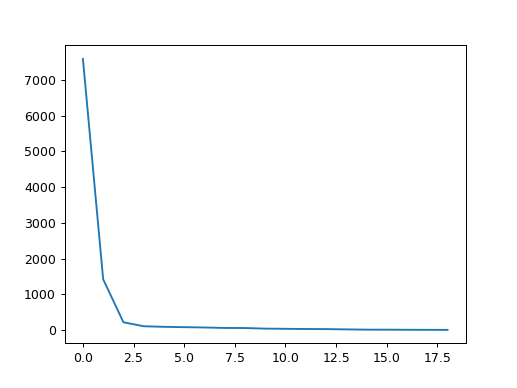

In [377]:
# Whoa!
plt.figure(121)
plt.plot(S)


In [279]:
# let's zoom in
plt.figure(121)
plt.plot(S[:10])

In [280]:
# let's zoom in
plt.plot(S[:3])

In [378]:
# Can we figure out by looking at V.T which the two most important features are?
len(VT[0]), VT[0]
V1 = pd.DataFrame(VT[0])

In [379]:
V1.columns

RangeIndex(start=0, stop=1, step=1)

In [380]:
V1['abs'] = [abs(x) for x in V1[0]]

In [381]:
V1.sort_values(by='abs')

0       abs
15  0.000000  0.000000
17 -0.000002  0.000002
16 -0.000009  0.000009
5  -0.000024  0.000024
12 -0.000037  0.000037
10 -0.000339  0.000339
4  -0.000772  0.000772
0  -0.001127  0.001127
9  -0.001874  0.001874
3  -0.003177  0.003177
8  -0.003366  0.003366
13 -0.003378  0.003378
11 -0.004118  0.004118
2  -0.005618  0.005618
7  -0.010684  0.010684
14 -0.015044  0.015044
18 -0.038644  0.038644
1  -0.692399  0.692399
6  -0.720183  0.720183

In [382]:
# 3 features that are most "representative" of the data - i.e. other columns give mostly redundant information
train_features.columns[6],train_features.columns[1],train_features.columns[18],train_features.columns[14] 

('complainant_age_incident', 'mos_age_incident', 'fado', 'c_male')

In [383]:
# let's project onto the 3D subspace and see how well our data fits there

data_mean = train_features.mean( axis = 0)[ None ,:]
data_std = train_features.std( axis = 0)[ None ,:] + 1e-10
train_features = ( train_features - data_mean ) / data_std
# test_data = ( test_data - data_mean ) / data_std

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


In [384]:
#data_mean

In [385]:
z

array([[ 0.72215716, -0.44659563],
       [-0.33720955, -0.64456872],
       [-0.59104656,  0.23574156],
       ...,
       [ 0.00863585,  2.22582768],
       [-0.79928693,  2.01951721],
       [ 0.36052473,  1.04328529]])

In [386]:
outcome_breakdown

outcome
-1.0    12379
 0.0     7572
 1.0     6615
Name: mos_gender, dtype: int64

<IPython.core.display.Javascript object>


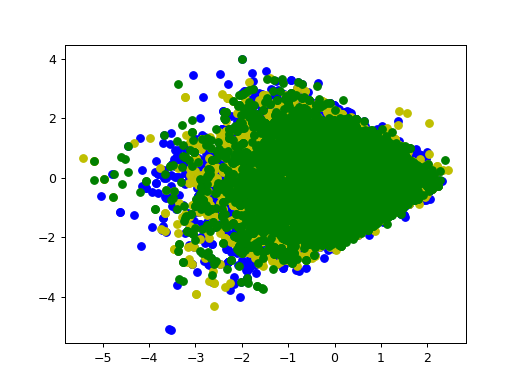

In [387]:
pc = VT [:2 , :] @ train_features.T
z = pc.T.to_numpy()
%matplotlib notebook
fig = plt.figure(21)
# ax = fig.add_subplot(111, projection="3d")


# sorted on fado
# plt.scatter(z[:16263,0] , z[:16263,1], c ='b')
# plt.scatter ( z [16263:16263+6028 ,0] , z [16263:16263+6028 ,1], c ='y')
# plt.scatter ( z [16263+6028:16263+6028+3675 ,0] , z [16263+6028:16263+6028+3675 ,1], c ='g')
# plt.scatter ( z [16263+6028+3675:16263+6028+3675+600 ,0] , z [16263+6028+3675:16263+6028+3675+600 ,1], c ='r')


# sorted on promotion
# plt.scatter(z[:13945,0] , z[:13945,1], c ='b')
# plt.scatter ( z [13945: ,0] , z [13945: ,1], c ='y')

# sorted on outcome
plt.scatter(z[:12379,0] , z[:12379,1], c ='b')
plt.scatter ( z [12379:12379+7572 ,0] , z [12379:12379+7572 ,1], c ='y')
plt.scatter ( z [12379+7572: ,0] , z [12379+7572: ,1] , c ='g')

<IPython.core.display.Javascript object>


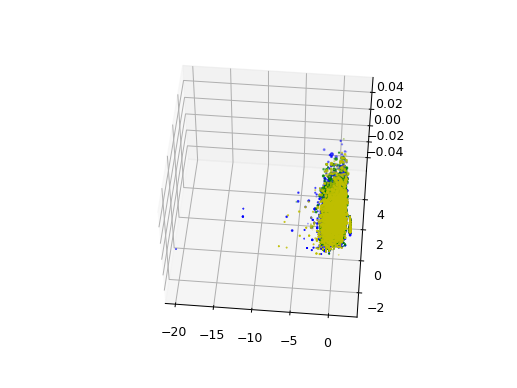

In [111]:
pc = VT [:3 , :] @ train_features.T
z = pc.T.to_numpy()
%matplotlib notebook
fig = plt.figure(21)
ax = fig.add_subplot(111, projection="3d")
plt.scatter(z[:12379,0] , z[:12379,1],z[:12379,2], c ='b')
plt.scatter ( z [12379:12379+7572 ,0] , z [12379:12379+7572 ,1],z [12379:12379+7572 ,2] , c ='y')
plt.scatter ( z [12379+7572: ,0] , z [12379+7572: ,1],z [12379+7572: ,2] , c ='g')

# plt . scatter ( z [:100 ,0] , z [:100 ,1] , c =’b’)

# p = ax.scatter(proj[:, 0], proj[:, 1], proj[:, 2],c='r')

In [77]:
z

0         1         2
0     -0.088609  0.361441  0.411401
1      0.317178 -1.276729  0.782107
2      0.317798 -1.282621  0.784995
3     -0.835951  0.037498  1.689721
4      0.763634 -0.372787 -1.736095
...         ...       ...       ...
33353  0.768798 -0.330194 -1.059351
33354  0.767305 -0.320453 -1.071050
33355  0.766723 -0.318726 -1.068694
33356  0.766881 -0.318479 -1.070607
33357  0.766747 -0.319329 -1.071047

[26566 rows x 3 columns]